# BLS and Population Data Analysis

This notebook performs an analysis of Bureau of Labor Statistics (BLS) data in conjunction with US population data.

In [ ]:
import pandas as pd
import json
import logging
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger(__name__)

## Load and Preprocess BLS Current Data

In this section, we load the BLS current data file and perform initial data cleaning.

In [ ]:
bls_current_df = pd.read_csv(
    "hd_files/bls/data/pr.data.0.Current", delimiter="\t", dtype=str
)
bls_current_df.columns = bls_current_df.columns.str.strip()
bls_current_df = bls_current_df.apply(
    lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x)
)
bls_current_df["year"] = bls_current_df["year"].astype("int32")
bls_current_df["value"] = bls_current_df["value"].astype(float).round(3)

print(bls_current_df)
print(bls_current_df.info())


         series_id  year period    value footnote_codes
0      PRS30006011  1995    Q01    2.600            NaN
1      PRS30006011  1995    Q02    2.100            NaN
2      PRS30006011  1995    Q03    0.900            NaN
3      PRS30006011  1995    Q04    0.100            NaN
4      PRS30006011  1995    Q05    1.400            NaN
...            ...   ...    ...      ...            ...
36646  PRS88003203  2023    Q04  115.334            NaN
36647  PRS88003203  2023    Q05  115.509            NaN
36648  PRS88003203  2024    Q01  116.936            NaN
36649  PRS88003203  2024    Q02  116.544            NaN
36650  PRS88003203  2024    Q03  116.593              R

[36651 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36651 entries, 0 to 36650
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   series_id       36651 non-null  object 
 1   year            36651 non-null  int32  
 2   period   

## Fetch US Population Data

Retrieve population data from the DataUSA API and process the response.

In [ ]:
with open("hd_files/population/data/population.json", "r") as file:
    population_dict = json.load(file)
population_data_df = pd.json_normalize(population_dict["data"])
population_source_df = pd.json_normalize(population_dict["source"])

print(population_data_df)

   ID Nation         Nation  ID Year  Year  Population    Slug Nation
0    01000US  United States     2023  2023   332387540  united-states
1    01000US  United States     2022  2022   331097593  united-states
2    01000US  United States     2021  2021   329725481  united-states
3    01000US  United States     2020  2020   326569308  united-states
4    01000US  United States     2019  2019   324697795  united-states
5    01000US  United States     2018  2018   322903030  united-states
6    01000US  United States     2017  2017   321004407  united-states
7    01000US  United States     2016  2016   318558162  united-states
8    01000US  United States     2015  2015   316515021  united-states
9    01000US  United States     2014  2014   314107084  united-states
10   01000US  United States     2013  2013   311536594  united-states


## Population Statistics (2013-2018)

Calculate mean and standard deviation of US population for the years 2013-2018.

In [ ]:
filtered_population_data_df = population_data_df[
    (population_data_df["ID Year"] >= 2013) & (population_data_df["ID Year"] <= 2018)
]
mean_population = filtered_population_data_df["Population"].mean()
std_population = filtered_population_data_df["Population"].std()

print(f"Mean Population (2013-2018): {mean_population}")
print(f"Standard Deviation of Population (2013-2018): {std_population}")


Mean Population (2013-2018): 317437383.0
Standard Deviation of Population (2013-2018): 4257089.5415293295


#### Visualization

Plot to visualize the mean and standard deviation of population

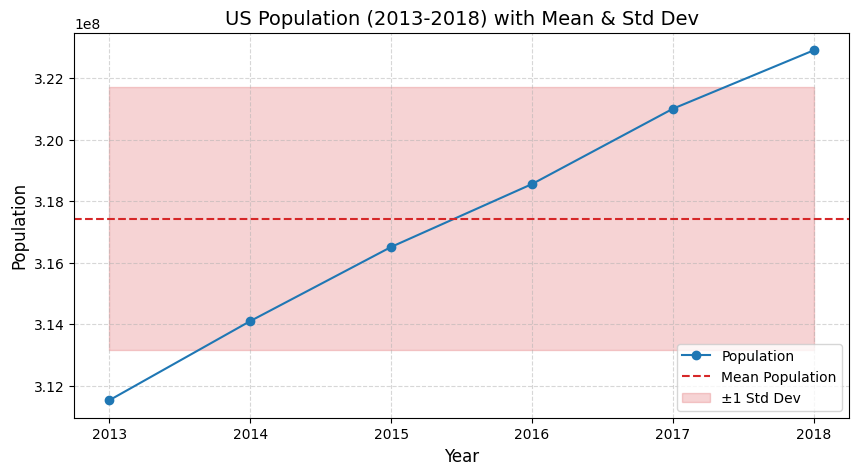

In [ ]:
years = filtered_population_data_df["ID Year"]
populations = filtered_population_data_df["Population"]

# Create visualization
plt.figure(figsize=(10, 5))
plt.plot(
    years, populations, marker="o", linestyle="-", color="tab:blue", label="Population"
)

# Add Mean Line
plt.axhline(mean_population, color="tab:red", linestyle="--", label="Mean Population")

# Add Shaded Std Dev Area
plt.fill_between(
    years,
    mean_population - std_population,
    mean_population + std_population,
    color="tab:red",
    alpha=0.2,
    label="±1 Std Dev",
)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("US Population (2013-2018) with Mean & Std Dev", fontsize=14)
plt.xticks(years)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Best Year Analysis by Series ID

Determine the best year for each series ID based on the maximum summed value.

In [ ]:
yearly_series_value_sum_df = (
    bls_current_df.groupby(["series_id", "year"])["value"].sum().reset_index()
)
series_best_year_by_value_df = yearly_series_value_sum_df.loc[
    yearly_series_value_sum_df.groupby("series_id")["value"].idxmax()
]
series_best_year_by_value_df = series_best_year_by_value_df.rename(
    columns={"value": "summed_value"}
)

print(series_best_year_by_value_df)


        series_id  year  summed_value
27    PRS30006011  2022        20.500
57    PRS30006012  2022        17.100
63    PRS30006013  1998       705.895
105   PRS30006021  2010        17.700
135   PRS30006022  2010        12.400
...           ...   ...           ...
8182  PRS88003192  2002       282.800
8233  PRS88003193  2023       847.203
8262  PRS88003201  2022        37.200
8292  PRS88003202  2022        28.700
8323  PRS88003203  2023       577.546

[282 rows x 3 columns]


## Merge BLS and Population Data

Merge BLS data for the 'PRS30006032' series (Q01 period) with population data.

In [ ]:
filtered_bls_current_df = bls_current_df[
    (bls_current_df["series_id"] == "PRS30006032") & (bls_current_df["period"] == "Q01")
]
merged_bls_population_df = filtered_bls_current_df.merge(
    population_data_df, left_on="year", right_on="ID Year", how="left"
)
merged_bls_population_df = merged_bls_population_df[
    merged_bls_population_df["Population"].notna()
]
merged_bls_population_df = merged_bls_population_df[
    ["series_id", "year", "period", "value", "Population"]
].sort_values(by="year")

print(merged_bls_population_df)


      series_id  year period  value   Population
18  PRS30006032  2013    Q01    0.5  311536594.0
19  PRS30006032  2014    Q01   -0.1  314107084.0
20  PRS30006032  2015    Q01   -1.7  316515021.0
21  PRS30006032  2016    Q01   -1.4  318558162.0
22  PRS30006032  2017    Q01    0.9  321004407.0
23  PRS30006032  2018    Q01    0.5  322903030.0
24  PRS30006032  2019    Q01   -1.6  324697795.0
25  PRS30006032  2020    Q01   -7.0  326569308.0
26  PRS30006032  2021    Q01    0.7  329725481.0
27  PRS30006032  2022    Q01    5.2  331097593.0
28  PRS30006032  2023    Q01    0.3  332387540.0


#### Visualization

Plots to compare BLS values and population over the years.

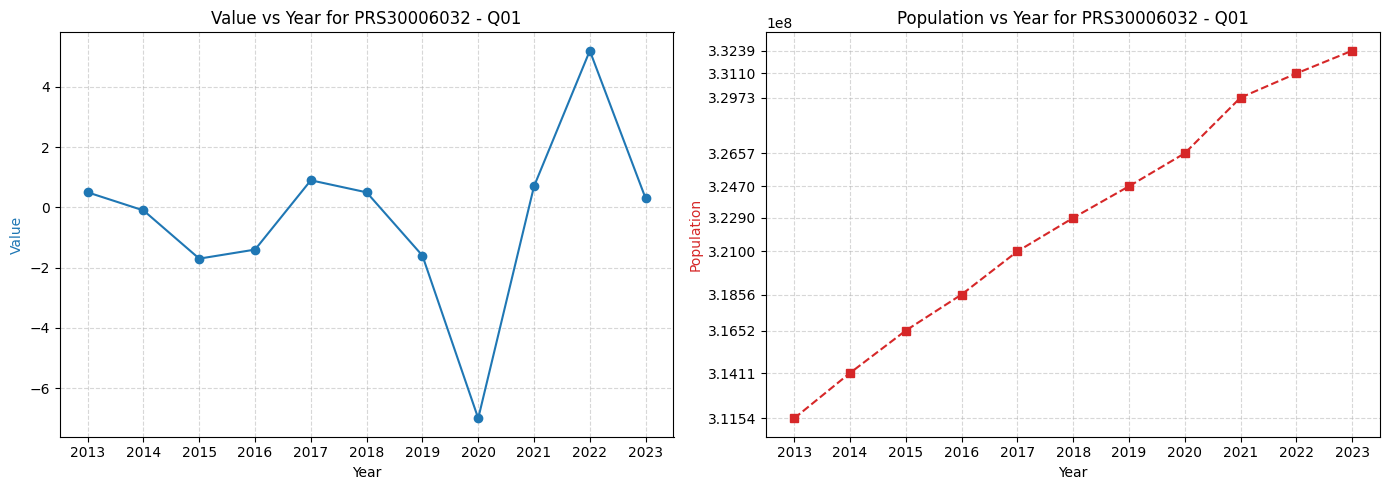

In [31]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
years = merged_bls_population_df["year"].unique()
populations = merged_bls_population_df["Population"].unique()

# BLS Value Plot
axes[0].plot(
    merged_bls_population_df["year"],
    merged_bls_population_df["value"],
    marker="o",
    linestyle="-",
    color="tab:blue",
)
axes[0].set_title(
    f"Value vs Year for {merged_bls_population_df['series_id'].iloc[0]} - {merged_bls_population_df['period'].iloc[0]}"
)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Value", color="tab:blue")
axes[0].set_xticks(years)
axes[0].grid(True, linestyle="--", alpha=0.5)

# Population Plot
axes[1].plot(
    merged_bls_population_df["year"],
    merged_bls_population_df["Population"],
    marker="s",
    linestyle="--",
    color="tab:red",
)
axes[1].set_title(
    f"Population vs Year for {merged_bls_population_df['series_id'].iloc[0]} - {merged_bls_population_df['period'].iloc[0]}"
)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Population", color="tab:red")
axes[1].set_xticks(years)
axes[1].set_yticks(populations)
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
